# Van Der Pol Oscillator
The van der Pol equation is an ordinary differential equation that can be derived from the Rayleigh differential equation by differentiating and setting y=y'. It is an equation describing self-sustaining oscillations in which energy is fed into small oscillations and removed from large oscillations. This equation arises in the study of circuits containing vacuum tubes and is given by

\begin{align*}
y'' - \mu(1 - y^2)y' + y = 0
\end{align*}


To build a Van der Pol Oscillator model in Python, we'll use the Runge-Kutta 4th order method (RK4) to solve the oscillator's differential equations over time. This method provides a good balance between computational efficiency and the accuracy needed for simulating nonlinear systems like the Van der Pol oscillator. 


\begin{align*}
\frac{dy(t)}{dt} = y'(t) = f(y(t), t), \quad \text{with} \quad y(t_0) = y_0
\end{align*}

\begin{align*}
k_1 &= f(y^*(t_0), t_0) \\
k_2 &= f\left(y^*(t_0) + \frac{k_1 h}{2}, t_0 + \frac{h}{2}\right) \\
k_3 &= f\left(y^*(t_0) + \frac{k_2 h}{2}, t_0 + \frac{h}{2}\right) \\
k_4 &= f(y^*(t_0) + k_3 h, t_0 + h)
\end{align*}

[Fourth Order Runge-Kutta](https://lpsa.swarthmore.edu/NumInt/NumIntFourth.html)


In [5]:
import numpy as np
import matplotlib.pyplot as plt

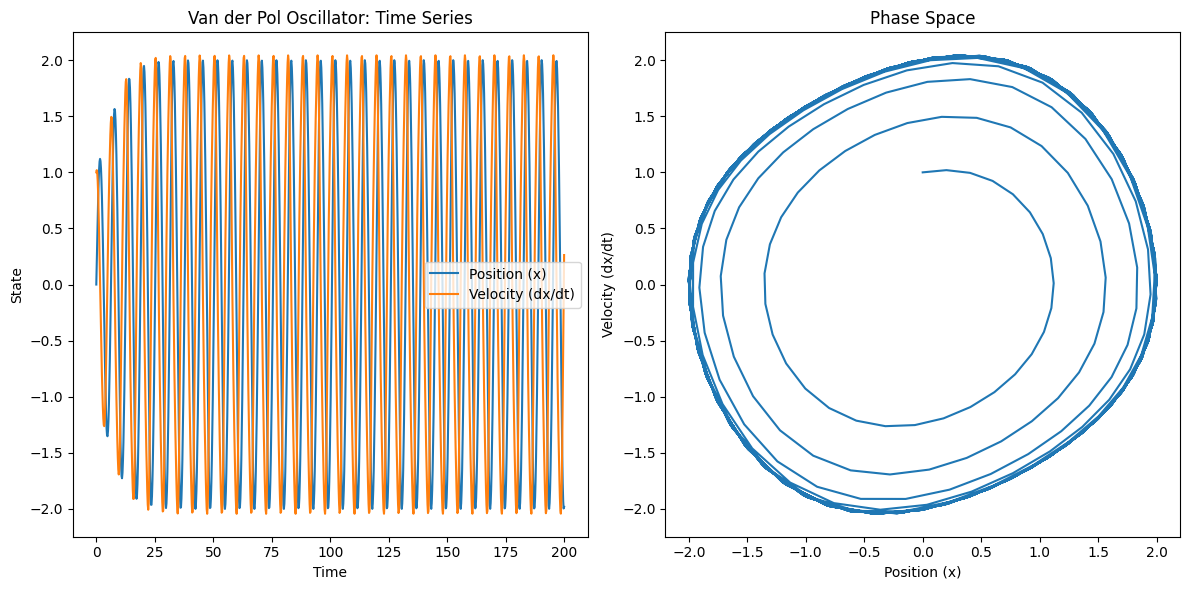

In [6]:
# Define the differential equations for the Van der Pol Oscillator
def van_der_pol_oscillator(t, y, mu):
    x, v = y  # y contains position and velocity
    dxdt = v
    dvdt = mu * (1 - x**2) * v - x
    return np.array([dxdt, dvdt])

# Implement the RK4 method
def rk4(t0, y0, t1, n, mu):
    dt = (t1 - t0) / n
    t = t0
    y = y0
    ys = [y0]
    ts = [t0]
    
    for _ in range(n):
        k1 = van_der_pol_oscillator(t, y, mu)
        k2 = van_der_pol_oscillator(t + dt / 2, y + dt / 2 * k1, mu)
        k3 = van_der_pol_oscillator(t + dt / 2, y + dt / 2 * k2, mu)
        k4 = van_der_pol_oscillator(t + dt, y + dt * k3, mu)
        
        y = y + dt / 6 * (k1 + 2*k2 + 2*k3 + k4)
        t = t + dt
        ys.append(y)
        ts.append(t)
        
    return np.array(ts), np.array(ys)

# Simulation parameters
t0 = 0  # start time
t1 = 200  # end time
n = 1000  # number of steps
y0 = np.array([0.0, 1.0])  # initial condition (position, velocity)
mu = 0.2  # nonlinearity parameter

# Run the simulation
ts, ys = rk4(t0, y0, t1, n, mu)

# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(ts, ys[:, 0], label='Position (x)')
plt.plot(ts, ys[:, 1], label='Velocity (dx/dt)')
plt.title('Van der Pol Oscillator: Time Series')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(ys[:, 0], ys[:, 1])
plt.title('Phase Space')
plt.xlabel('Position (x)')
plt.ylabel('Velocity (dx/dt)')

plt.tight_layout()
plt.show()


In [8]:
import numpy as np

def ekf_predict(x, P, Q, dt, mu):
    """
    EKF Prediction Step for the Van der Pol Oscillator.
    
    Parameters:
    - x: The state estimate vector at time t-1.
    - P: The covariance of the state estimate at time t-1.
    - Q: The process noise covariance matrix.
    - dt: Time step.
    - mu: Nonlinearity parameter of the Van der Pol oscillator.
    
    Returns:
    - x_pred: Predicted state estimate vector at time t.
    - P_pred: Predicted covariance of the state estimate at time t.
    """
    # State transition function (f) and Jacobian (F) of the Van der Pol oscillator
    A = np.array([[0, 1], [-1, mu*(1 - x[0]**2)]])
    F = np.eye(2) + A * dt  # Linear approximation
    
    # Predict state
    x_pred = x + np.array([x[1], mu * (1 - x[0]**2) * x[1] - x[0]]) * dt
    
    # Predict covariance
    P_pred = F @ P @ F.T + Q
    
    return x_pred, P_pred

def ekf_update(x_pred, P_pred, z, R, H):
    """
    EKF Update Step.
    
    Parameters:
    - x_pred: Predicted state estimate vector.
    - P_pred: Predicted covariance of the state estimate.
    - z: The measurement vector at time t.
    - R: The measurement noise covariance matrix.
    - H: The measurement matrix.
    
    Returns:
    - x_upd: Updated state estimate vector after incorporating measurement z.
    - P_upd: Updated covariance of the state estimate after incorporating measurement z.
    """
    # Measurement update
    S = H @ P_pred @ H.T + R  # Residual covariance
    K = P_pred @ H.T @ np.linalg.inv(S)  # Kalman gain
    
    y = z - H @ x_pred  # Measurement residual
    x_upd = x_pred + K @ y
    P_upd = P_pred - K @ H @ P_pred
    
    return x_upd, P_upd

# Example usage
dt = 0.01  # Time step
mu = 0.2  # Nonlinearity parameter
x = np.array([0.0, 2.0])  # Initial state estimate
P = np.eye(2) * 0.1  # Initial state covariance
Q = np.eye(2) * 0.01  # Process noise covariance
R = np.eye(1) * 0.1  # Measurement noise covariance
H = np.array([[1, 0]])  # Measurement matrix

# Simulate a single predict-update cycle
x_pred, P_pred = ekf_predict(x, P, Q, dt, mu)
# Assuming a measurement of the position
z = np.array([1.95])  # Example measurement
x_upd, P_upd = ekf_update(x_pred, P_pred, z, R, H)

print("Updated State:", x_upd)
print("Updated Covariance:\n", P_upd)


Updated State: [1.03099614 2.00401838]
Updated Covariance:
 [[5.23832198e-02 9.52335603e-07]
 [9.52335603e-07 1.10410400e-01]]
